# Measure Relationship to Other Channels by Code

This notebook shows how to measure features of segmentated objects arising from multichannel images. It shows the similar steps done via the "Regionprops Measure Relationship to Other Channels" plugin module, but here these are applied by calling different functions. 

It shows how to do that in the following ways (the first 2 are a wrapper around the regular single channel "Regionprops" plugin module):

1. **measure_labels**: Get features from on one segmented image (it needs one label image);
    
2. **measure_labels_with_intensity**: Get features (including intensity) from one segmented image and one intensity image (it needs one label image and one intensity image);

3. **link_two_label_images**: Get which objects from one segmented image "belong" or "are inside" another reference image, returning a relationship table;
    
4. **measure_labels_in_labels**: Get features from two segmented images, relating objects from one image to another image (it needs two label images, one being a reference), returning a (list of) relationship table(s) with features;
    
5. **measure_labels_in_labels_with_intensity**: Get features (including intensity features) from two segmented images and two intensity images (it needs two label images and two intensity images), returning a (list of) relationship table(s) with features;

6. **measure_summary_statistics**: Transforms a (list of) relationship table(s) to return a single summary statistics table instead of individual direct relationships.

We start by loading the same cropped images from the [BBBC007 dataset](https://bbbc.broadinstitute.org/BBBC007): two label images and two intensity images.

In [1]:
from skimage import io
import numpy as np
import pandas as pd
import napari
from napari.utils import nbscreenshot
from napari_skimage_regionprops import measure_labels, measure_labels_with_intensity
from napari_skimage_regionprops import measure_labels_in_labels, measure_labels_in_labels_with_intensity
from napari_skimage_regionprops import link_two_label_images, make_summary_table
from napari_skimage_regionprops import regionprops_table

In [2]:
image_channel1 = io.imread('../data/actin.tif')
image_channel2 = io.imread('../data/dna.tif')
cell_labels = io.imread('../data/cell_labels.tif')
dna_labels = io.imread('../data/dna_labels.tif')

In [3]:
viewer = napari.Viewer()

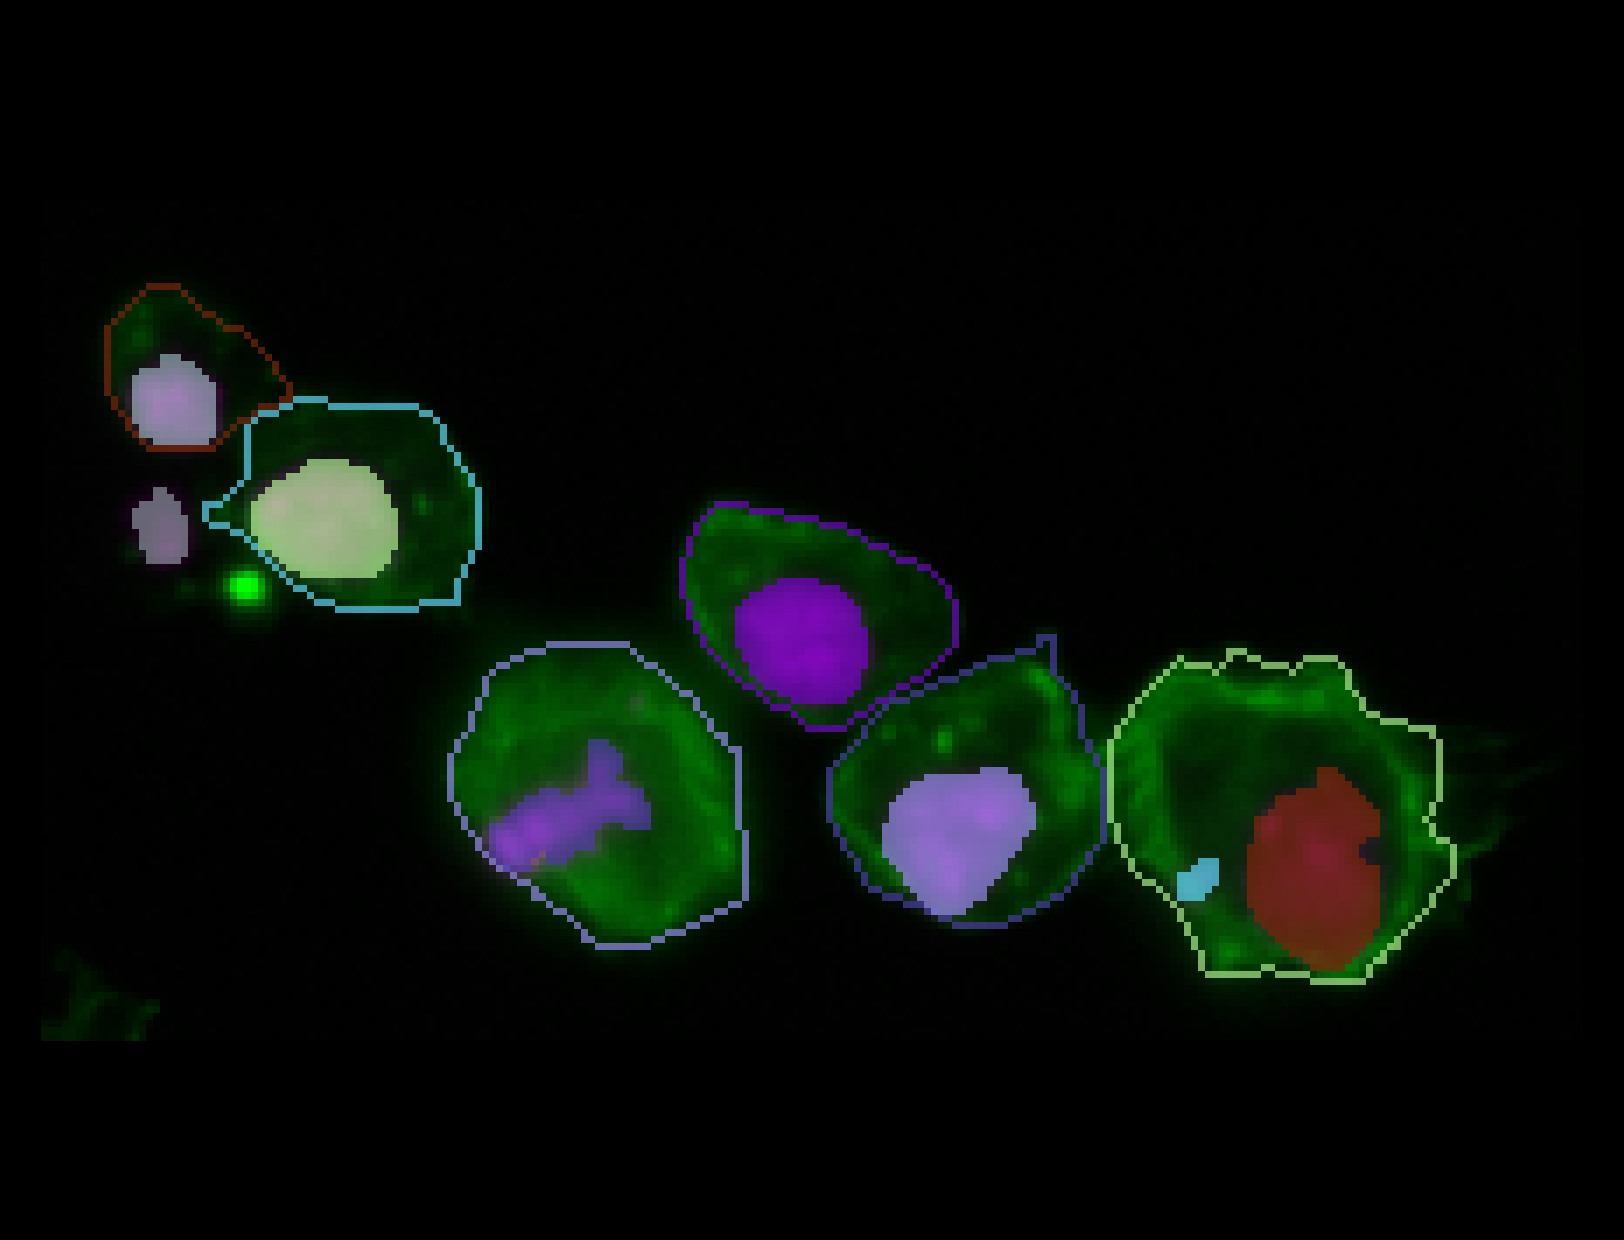

In [4]:
viewer.add_image(image_channel1, name = 'cell', colormap='green')
viewer.add_image(image_channel2, name = 'dna', colormap='magenta', blending='additive')
cell_labels_layer = viewer.add_labels(cell_labels)
cell_labels_layer.contour = 1
dna_labels_layer = viewer.add_labels(dna_labels)
nbscreenshot(viewer, canvas_only=True)

## 1. Measure Lables

To measure cell size features from one label image, we can use the function `measure_labels` providing the labeled image as an argument. By doing that, we get a table with size and shape properties.

In [5]:
measurements = measure_labels(label_image_reference=cell_labels)
measurements

,label,area,bbox_area,equivalent_diameter,convex_area
0,1,442,648,23.722813,461
1,2,910,1240,34.038919,972
2,3,1407,1892,42.325501,1452
3,4,911,1320,34.057616,941
4,5,1185,1680,38.843131,1231
5,6,1803,2400,47.912951,1919


Extra properties can be provided to get other features like `shape`.

In [6]:
measurements = measure_labels(label_image_reference=cell_labels, shape=True)
measurements

,label,area,bbox_area,equivalent_diameter,convex_area,extent,local_centroid-0,local_centroid-1,solidity,feret_diameter_max,major_axis_length,minor_axis_length,orientation,eccentricity,aspect_ratio,roundness,circularity
0,1,442,648,23.722813,461,0.682099,12.248869,11.158371,0.958785,28.792360,26.534396,21.946451,1.114467,0.562063,1.209052,0.799308,0.884261
1,2,910,1240,34.038919,972,0.733871,15.034066,21.548352,0.936214,40.607881,38.480267,30.581397,1.219138,0.606964,1.258290,0.782484,0.820115
2,3,1407,1892,42.325501,1452,0.743658,21.185501,21.783937,0.969008,49.040799,47.789939,37.707490,0.739053,0.614360,1.267386,0.784389,0.863983
3,4,911,1320,34.057616,941,0.690152,15.396268,18.670692,0.968119,42.154478,41.248159,28.712921,1.186024,0.717943,1.436571,0.681741,0.856081
4,5,1185,1680,38.843131,1231,0.705357,22.182278,20.661603,0.962632,45.486262,41.268687,37.257503,-0.896798,0.430054,1.107661,0.885905,0.833792
5,6,1803,2400,47.912951,1919,0.751250,23.469773,24.153078,0.939552,53.851648,52.248724,44.392437,0.893456,0.527368,1.176974,0.840920,0.770883


## 2. Measure cell intensity features

To also include intensity features, we use the `measure_labels_with_intensity` function, which needs a label image and an intensity single-channel image.

In [7]:
measurements_with_intensity = measure_labels_with_intensity(
    label_image_reference=cell_labels,
    intensity_image_reference=image_channel1
)
measurements_with_intensity

,label,area,bbox_area,equivalent_diameter,convex_area,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity
0,1,442,648,23.722813,461,64.0,23.988688,9.0,10.084142
1,2,910,1240,34.038919,972,96.0,42.542857,16.0,14.954136
2,3,1407,1892,42.325501,1452,128.0,72.480455,24.0,16.704404
3,4,911,1320,34.057616,941,105.0,45.803513,14.0,16.341103
4,5,1185,1680,38.843131,1231,135.0,51.278481,20.0,19.006819
5,6,1803,2400,47.912951,1919,136.0,56.301165,16.0,24.383326


## 3. Link each cell to objects in another channel

To get the relationship of each labeled object in one label image (reference) to other labeled objects in a second (target) label image, we can use the `link_two_label_images` function.

In [8]:
labels_relationship = link_two_label_images(
    label_image_reference=cell_labels,
    label_image_other_channel=dna_labels,
)
labels_relationship

,label_reference,label_target
0,0,8
1,1,7
2,2,6
3,3,5
4,4,4
5,5,3
6,6,1
7,6,2


This tells us that the object with label `8` from the DNA labels (`label_target` column) 'belongs' to the background of the cell labels (label `0` from `label_reference` column).

Also, that the object `7` from the DNA labels 'belongs' to the cell with label `1`.

Finally, labels `1` and `2` from the DNA labels are considered 'inside' cell label `6`. That's why label `6` appears twice.

To understand in more detail how an object is considered to belong to another, please refer to the [´intersection_over_target_area_explained´ notebook](https://github.com/haesleinhuepf/napari-skimage-regionprops/tree/master/demo/intersection_over_target_area_explained.ipynb).

## 4. Link each cell with its features to objects in another channel, also with their features

To get not only the label relationships shown above, but also to get the corresponding properties in a same table, we can use the `measure_labels_in_labels` function. We can optionally provide `suffixes` to better identify the sources, otherwise '_reference' and increasing numbers will be used.

*Notice that the return output of this function is a list of tables (each relationship of a channel to the reference yields a new table with possibly different shapes).*
*In this example, we get the single element of the list `[0]` since we have a single extra channel besides the reference.*

In [9]:
measurements_linked = measure_labels_in_labels(label_image_reference=cell_labels,
                                                label_image_other_channel=dna_labels,
                                                suffixes=['_cells', '_dna'])
measurements_linked[0]

c:\users\mazo260d\documents\github\napari-skimage-regionprops\napari_skimage_regionprops\_process_tables.py:86: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  output_table = pd.merge(table_reference_labels_properties,


,label_cells,area_cells,bbox_area_cells,equivalent_diameter_cells,convex_area_cells,label_dna,area_dna,bbox_area_dna,equivalent_diameter_dna,convex_area_dna
7,0,NaN,NaN,NaN,NaN,8,66,88,9.166996,70
0,1,442.0,648.0,23.722813,461.0,7,130,156,12.865502,135
1,2,910.0,1240.0,34.038919,972.0,6,283,357,18.982276,293
2,3,1407.0,1892.0,42.325501,1452.0,5,210,437,16.351768,271
3,4,911.0,1320.0,34.057616,941.0,4,275,342,18.712052,284
4,5,1185.0,1680.0,38.843131,1231.0,3,329,462,20.466944,345
5,6,1803.0,2400.0,47.912951,1919.0,1,413,551,22.931374,437
6,6,1803.0,2400.0,47.912951,1919.0,2,28,36,5.970821,29


*Currently, background feature calculation is not implemented, so NaN are returned for it.*

Similarly to the ouput of `link_two_label_images`, this table provides direct relationships, so some labels may show up duplicated. To have unique labels in the first column, we should later apply the `make_summary_table` function explained in the last section of this notebook.

## 5. Link each cell with its features (including intensity features) to objects in another channel, also with their features

To also include intensity features, we use the function `measure_labels_in_labels_with_intensity`, which needs the corresponding intensity images as extra parameters.

*Similarly, this funtion also returns a list of tables.*

In [10]:
measurements_with_intensity_linked = measure_labels_in_labels_with_intensity(label_image_reference=cell_labels,
                                                                intensity_image_reference=image_channel1,
                                                                label_image_other_channel=dna_labels,
                                                                intensity_image_other_channel=image_channel2,
                                                                suffixes=['_cells', '_dna'])
measurements_with_intensity_linked[0]

c:\users\mazo260d\documents\github\napari-skimage-regionprops\napari_skimage_regionprops\_process_tables.py:86: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  output_table = pd.merge(table_reference_labels_properties,


,label_cells,area_cells,bbox_area_cells,equivalent_diameter_cells,convex_area_cells,max_intensity_cells,mean_intensity_cells,min_intensity_cells,standard_deviation_intensity_cells,label_dna,area_dna,bbox_area_dna,equivalent_diameter_dna,convex_area_dna,max_intensity_dna,mean_intensity_dna,min_intensity_dna,standard_deviation_intensity_dna
7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,66,88,9.166996,70,94.0,46.030303,22.0,17.076450
0,1,442.0,648.0,23.722813,461.0,64.0,23.988688,9.0,10.084142,7,130,156,12.865502,135,183.0,104.346154,19.0,40.762674
1,2,910.0,1240.0,34.038919,972.0,96.0,42.542857,16.0,14.954136,6,283,357,18.982276,293,182.0,99.568905,28.0,34.877849
2,3,1407.0,1892.0,42.325501,1452.0,128.0,72.480455,24.0,16.704404,5,210,437,16.351768,271,247.0,127.585714,24.0,55.615558
3,4,911.0,1320.0,34.057616,941.0,105.0,45.803513,14.0,16.341103,4,275,342,18.712052,284,173.0,96.658182,23.0,37.846574
4,5,1185.0,1680.0,38.843131,1231.0,135.0,51.278481,20.0,19.006819,3,329,462,20.466944,345,161.0,79.708207,10.0,32.925170
5,6,1803.0,2400.0,47.912951,1919.0,136.0,56.301165,16.0,24.383326,1,413,551,22.931374,437,132.0,58.987893,14.0,24.761279
6,6,1803.0,2400.0,47.912951,1919.0,136.0,56.301165,16.0,24.383326,2,28,36,5.970821,29,56.0,35.607143,13.0,11.564537


## 6. Get individual cell summary statistics for each feature

To get summary statistics instead of individual direct relationships, we can use the `make_linked_summary` function. We must provide as input the list of direct relationships tables and a list of desired statistics. 

Below, we provide 'count' and 'average'. So, for each cell label, we get the number of objects 'inside' it and the average of `size` features, like average area of the DNA objects inside each cell.

In [11]:
measurements_linked_summary = make_summary_table(measurements_linked,
                                                statistics_list=['count', 'average'])
measurements_linked_summary

,label_cells,counts_dna,area_dna average,bbox_area_dna average,equivalent_diameter_dna average,convex_area_dna average
0,0,1,66.0,88.0,9.166996,70.0
1,1,1,130.0,156.0,12.865502,135.0
2,2,1,283.0,357.0,18.982276,293.0
3,3,1,210.0,437.0,16.351768,271.0
4,4,1,275.0,342.0,18.712052,284.0
5,5,1,329.0,462.0,20.466944,345.0
6,6,2,220.5,293.5,14.451098,233.0
